# Environment Setup

In [11]:
# Packages
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, d2_tweedie_score
from scipy.special import factorial
import autograd
import math
import torch
#from ucimlrepo import fetch_ucirepo 

# Parameters
# folder location for the data
DATA_DIR = r"C:\Users\Welcome\Documents\MScAC\CS2515\HW2\data\\"
# Random state (to be used in shuffle)

RANDOM_STATE = 0
BATCH_SIZE = 1000
EPOCHS = 1000
LR = 0.000001
CLIP_NUM = 0.05

# Question 1 Plot

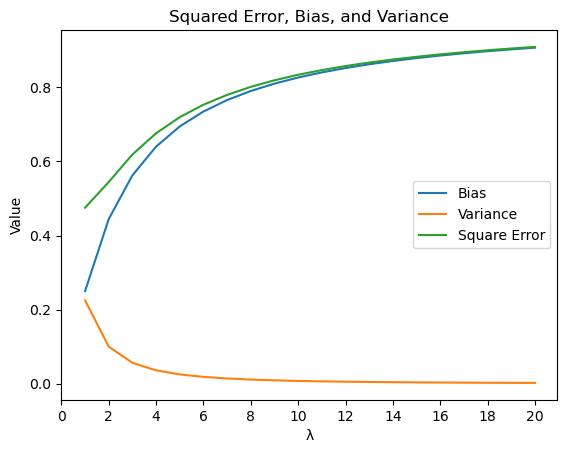

In [12]:
# Inputs
X = np.linspace(1,20,20)
mu = 1
sigma2 = 9
n = 10

#Helper functions
def bias(l, mu):
    return ((l*mu)/(l+1))**2

def variance(l,sigma2, n):
    return(sigma2)/(n*(l+1)**2)

def sq_error(l,mu,sigma2,n):
    return bias(l,mu)+variance(l,sigma2,n)

plt.plot(X,bias(X,mu), label = "Bias")
plt.plot(X,variance(X,sigma2,n), label = "Variance")
plt.plot(X,sq_error(X,mu,sigma2,n), label = "Square Error")
plt.title("Squared Error, Bias, and Variance")
plt.xlabel("λ")
plt.xticks(np.linspace(0,20,11))
plt.ylabel("Value")
plt.legend()


# Question 3

## 3.1 Initial Data Analysis

### (a) Data load

In [13]:
# Loading bikeshare data
hours_file = DATA_DIR + "hour.csv"
hours = pd.read_csv('../code/courses/CSC2515/hw2/bike+sharing+dataset/hour.csv', parse_dates= ['dteday'])

### (b) Data Summary
In the 'hour' file we have 17,379 observations (rows) across 17 dimensions (16 true dimensions and 1 index column). Here is a quick summary of the different dimensions and their datatypes from the dataset's website:
| Variable Name | Role     | Type        | Description                                                                                                 | Units | Missing Values |
|---------------|----------|-------------|-------------------------------------------------------------------------------------------------------------|-------|----------------|
| instant       | ID       | Integer     | record index                                                                                                |       | no             |
| dteday       | Feature  | Date        | date                                                                                                       |       | no             |
| season        | Feature  | Categorical | 1:winter, 2:spring, 3:summer, 4:fall                                                                      |       | no             |
| yr            | Feature  | Categorical | year (0: 2011, 1: 2012)                                                                                    |       | no             |
| mnth          | Feature  | Categorical | month (1 to 12)                                                                                            |       | no             |
| hr            | Feature  | Categorical | hour (0 to 23)                                                                                            |       | no             |
| holiday       | Feature  | Binary      | weather day is holiday or not (extracted from [DC Holiday Schedule](http://dchr.dc.gov/page/holiday-schedule)) |       | no             |
| weekday       | Feature  | Categorical | day of the week                                                                                             |       | no             |
| workingday    | Feature  | Binary      | if day is neither weekend nor holiday is 1, otherwise is 0                                                |       | no             |
| weathersit    | Feature  | Categorical | - 1: Clear, Few clouds, Partly cloudy, Partly cloudy                                                      |       | no             |
| temp          | Feature  | Continuous  | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) | C     | no             |
| atemp         | Feature  | Continuous  | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) | C     | no             |
| hum           | Feature  | Continuous  | Normalized humidity. The values are divided to 100 (max)                                                  |       | no             |
| windspeed     | Feature  | Continuous  | Normalized wind speed. The values are divided to 67 (max)                                                  |       | no             |
| casual        | Other    | Integer     | count of casual users                                                                                       |       | no             |
| registered     | Other    | Integer     | count of registered users                                                                                    |       | no             |
| cnt           | Target   | Integer     | count of total rental bikes including both casual and registered                                             |       | no             |

We can also use the pandas functions top summarize the data as shown below

In [14]:
hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [15]:
hours.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [16]:
hours.describe(include = "all")

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2012-01-02 04:08:34.552045568,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
min,1.0000,2011-01-01 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2011-07-04 00:00:00,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,2012-01-02 00:00:00,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,2012-07-02 00:00:00,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,2012-12-31 00:00:00,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000
std,5017.0295,NaN,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599


### (c) Plotting features
For categorical data I have chosen to use a boxplot to better show the dependent variable cnt against the different buckets. For numeric cateogories I have used a scatter plot.
From a quick inspection I see trends in:
- dteday: general upwards trends with troughs in the winter
- season: higher in seasons 2,3,4 spring, (summer, and fall)
- yr: higher in the second year (2012)
- mnth: More granular view of the seasons trend
- hr: peaks around commuting times 7-9 am and 4-7pm
- holiday: lower on holidays
- Fairly flat on all days of the week
- workingday: slightly higher on working days, with many high outliers
- weathersit: highest when the weather is clear
- temp: generally positive trend
- atemp: generally positive trend
- hum: not a very clear trend, maybe negative correlation for high humidities
- windspeed: negative trend with cnt
- casual: generally positive trend (expected as cnt = casual + registered)
- registered: generally positive trend (expected as cnt = casual + registered)

TypeError: Axes.boxplot() got an unexpected keyword argument 'tick_labels'

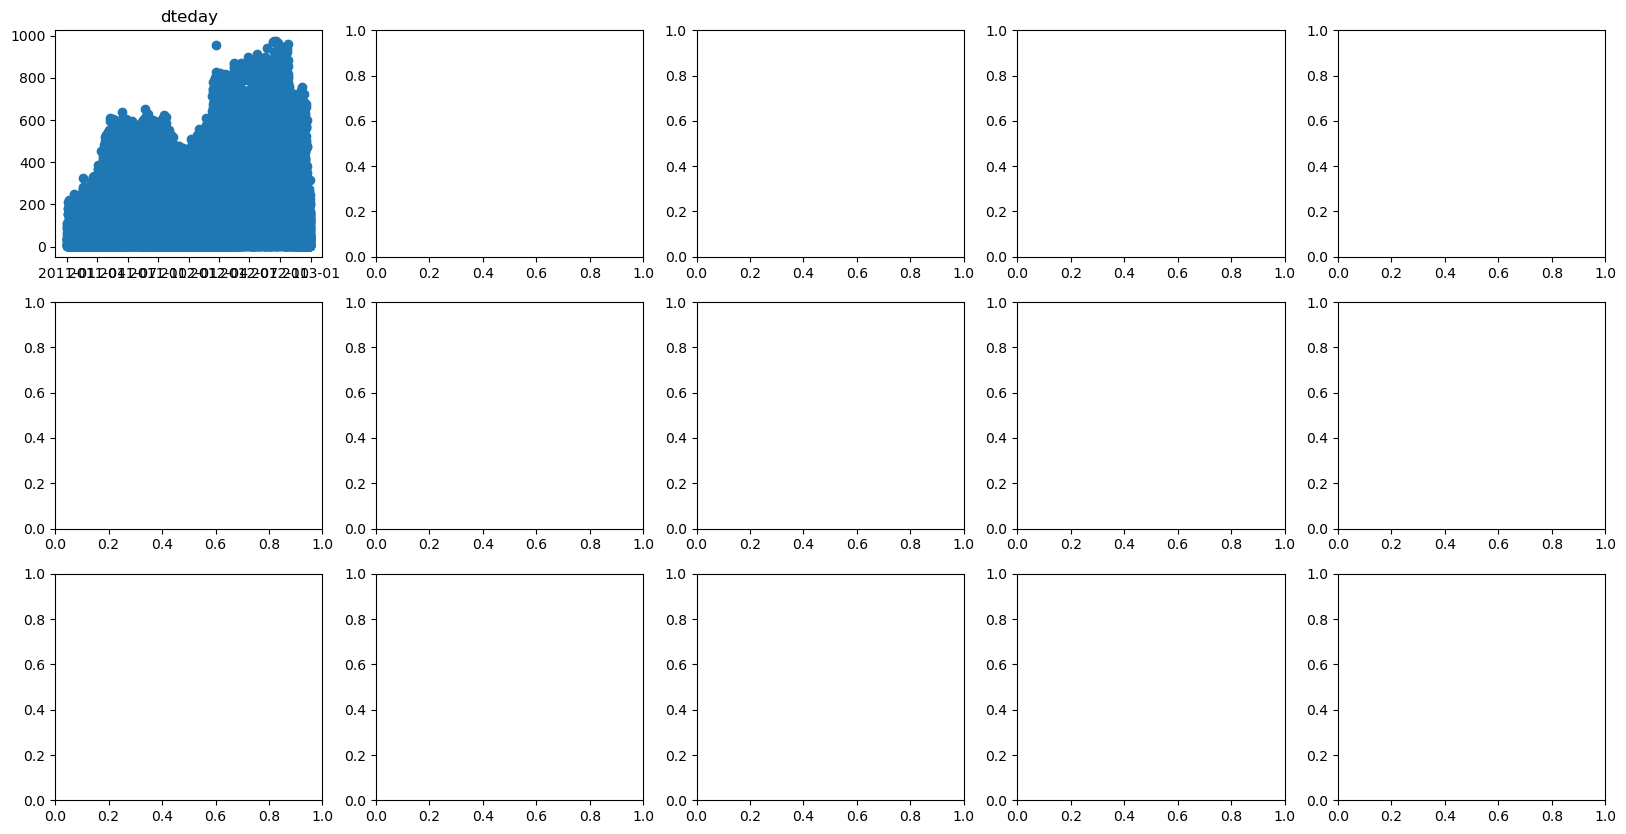

In [17]:
# Define the plot
fig, axs = plt.subplots(3, 5, figsize=(20, 10))#, height_ratios=[1, 1, 2])
features = list(hours.columns)[1:-1]

# Plot each feature based on the datatype
for ax, feature in zip(axs.flat, features):
    if hours[feature].dtype == "int64":
        grouped_data = [hours['cnt'][hours[feature] == cat] for cat in hours[feature].unique()]
        ax.boxplot(grouped_data, tick_labels=hours[feature].unique()) 
    elif hours[feature].dtype == "float64":
        ax.scatter(hours[feature],hours['cnt'])
    else:
        ax.scatter(hours[feature],hours['cnt'])
    ax.set_title(feature)

plt.tight_layout()
plt.show()

### (d) Correlation Analysis

The full correlation matrix can be viewed below. The highest correlation to cnt are casual and registered. However these aren't truly features, as they are really just a decomposition of our dependent variable (casual + registered = cnt). So lets look at what of the other features are most correlated:

**High Postive Correlation**
- temp: 0.40
- atemp: 0.40
- hr: 0.39

**High Negative Correlation**
- hum: -0.32
- weathersit: -0.14
- Note interestingly, windspeed does not have a negative correlation with cnt, this is most likely because most of the data exists at low windspeeds, so is overwhelming the trend

**Least Correlated**
- Holiday: -0.03
- Workday: 0.03
- Weekday: 0.03





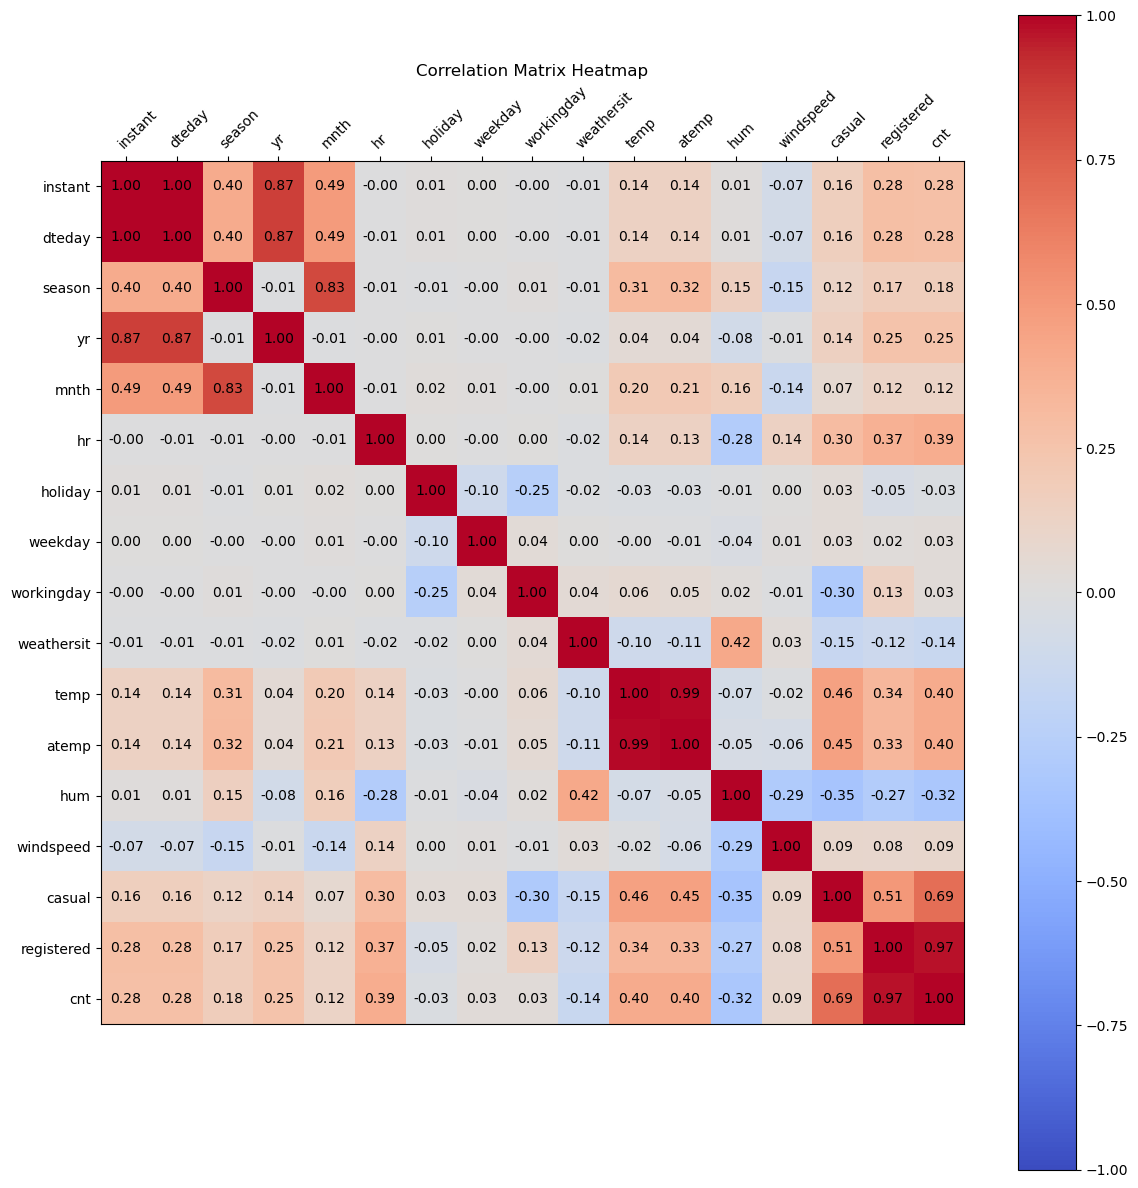

In [18]:
# Calculate correlation matrix using built in pd function 
corr_matrix = hours.corr()


# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
fig.colorbar(cax)
plt.title('Correlation Matrix Heatmap')

# Set x-ticks and y-ticks
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.index)
ax.xaxis.set_ticks_position('top')  # Move x-ticks to top

# Rotate the x-tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Include correlation coefficient within each cell
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.index)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')


# Show the plot
plt.tight_layout()
plt.show()

### (e-f) Dropping columns and splitting the dataset

In [19]:
# Drop columns specified by the homework
cols = ["instant","dteday","atemp","registered","casual"]
hours_clean = hours.drop(columns= cols)

# Helper function to split data
def train_test_split(data, random_state, split_index):
    

    #Shuffling dataframe and splitting into train and test
    data_clean = shuffle(data,random_state=random_state)
    train, test = data_clean[:split_index],data_clean[split_index:]
    

    # Split training data
    X_train = train.drop(columns=["cnt"])
    y_train = train["cnt"]

    #Split testing data
    X_test = test.drop(columns=["cnt"])
    y_test = test["cnt"]

    # Add bias term to dataset to simplify carrying a bias in following equations
    X_train["bias"] = 1
    X_test["bias"] = 1
    return X_train, y_train, X_test, y_test

# Saving cleaner naming conventions (i.e., no _v0) for once we one-hot encode to simplify code later on 
X_train_v0, y_train_v0, X_test_v0, y_test_v0 = train_test_split(hours_clean, RANDOM_STATE, split_index = 10000)



In [20]:
X_train_v0.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,bias
3439,2,0,5,5,0,6,0,1,0.56,0.88,0.2239,1
6542,4,0,10,4,0,3,1,1,0.44,0.88,0.0000,1
15470,4,1,10,19,0,4,1,1,0.44,0.51,0.1343,1
9851,1,1,2,11,1,1,0,1,0.26,0.48,0.3582,1
12640,2,1,6,21,0,5,1,1,0.66,0.50,0.1045,1


## 3.2 Regression Implementations

### (a-b) OLS regression

Using the closed form to find w as:
$$\textbf{w}^* =  (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\textbf{y}$$

The resulting R^2 score using OLS was 0.3769

In [22]:
# Get weights for ordinary least squares
def get_ols_weights(X_train, y_train):
    # Absorb the bias term into X
    #X_train["bias"] = 1
    
    #Determine weights
    xtx = X_train.T @ X_train
    xtx_inv = pd.DataFrame(np.linalg.pinv(xtx), xtx.columns, xtx.index)   
    w1 = xtx_inv @ X_train.T
    w = w1 @ y_train
    return w

def predict_ols_regression(X,w):
    #X["bias"] = 1
    y = X @ w
    return y

def calculate_r2(y_hat,y):
    return r2_score(y_hat,y)

# Evaluating OLS on data set
w = get_ols_weights(X_train_v0,y_train_v0)
y = predict_ols_regression(X_test_v0, w)
r2 = calculate_r2(y_test_v0, y)
# Print R2 value
print("R2 score of: {:.4f}".format(r2))

R2 score of: 0.3769


### (c) Converting data

In [23]:
# One Hot Encoding helper function
def one_hot_encode(data, columns):
    ohe_data = pd.get_dummies(data,columns=columns,dtype= "int")
    return ohe_data

# One hot encode columns specified by ohe_columns
ohe_columns = ["season","mnth","hr","weekday","weathersit"]
hours_ohe = one_hot_encode(hours_clean, ohe_columns)

# Resplit dataset
X_train, y_train, X_test, y_test = train_test_split(hours_ohe, random_state=RANDOM_STATE,split_index=10000)

print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3439 to 10813
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            10000 non-null  int64  
 1   holiday       10000 non-null  int64  
 2   workingday    10000 non-null  int64  
 3   temp          10000 non-null  float64
 4   hum           10000 non-null  float64
 5   windspeed     10000 non-null  float64
 6   season_1      10000 non-null  int64  
 7   season_2      10000 non-null  int64  
 8   season_3      10000 non-null  int64  
 9   season_4      10000 non-null  int64  
 10  mnth_1        10000 non-null  int64  
 11  mnth_2        10000 non-null  int64  
 12  mnth_3        10000 non-null  int64  
 13  mnth_4        10000 non-null  int64  
 14  mnth_5        10000 non-null  int64  
 15  mnth_6        10000 non-null  int64  
 16  mnth_7        10000 non-null  int64  
 17  mnth_8        10000 non-null  int64  
 18  mnth_9        10000 non-null

In [26]:
X_train.columns
for i in X_train.columns.tolist():
    if i not in ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3', 'weathersit_4']:
        print(i)



season_1
mnth_1
hr_0
weekday_0
weathersit_1
bias


### (c-d) Refitting OLS
The new R^2 score is 0.6818 which is considerably better than our previous score

In [639]:
w_ols = get_ols_weights(X_train,y_train)
y = predict_ols_regression(X_test, w_ols)
r2 = calculate_r2(y_test, y)

# Print R2 value
print("R2 score of: {:.4f}".format(r2))

R2 score of: 0.6818


### (e) Locally Weighted Regression
Implementing the locally weighted regression model from Q2.

In [38]:
# Helper functions to perform the locally weighted regression
def get_flat_A_matrix(x, X, tau):
    a = np.zeros(X.shape[0])
    for i,(_,x_i) in enumerate(X.iterrows()):
        exponent = - ((x-x_i).T @ (x-x_i))/(2*tau**2)
        a[i] = math.e ** exponent
    denominator = sum(a)
    return a / denominator

def diagonalize(a):
    A = np.zeros((len(a),len(a)))
    for i,_ in enumerate(a):
        A[i][i] = a[i]
    return A

def get_wls_weights(X_train, X_test, y_train, tau):
        # Converting to numpy arrays to avoid matmult issues
        X_train_np = np.array(X_train) # Shape (N,M)
        X_test_np = np.array(X_test) # Shape (L,M)
        y_train_np = np.array(y_train) #Shape (M,1)

        # To avoid looping we build A as a (LxM) matrix where each row are the diagonal values to be used
        # First we expand each of the train and test sets so they are of the form (L,N,M)
        X_train_exp = X_train_np[np.newaxis,:,:]
        X_test_exp = X_test_np[:,np.newaxis,:]
        # Get teh squared difference between each test and train X
        sq_diff = (X_test_exp - X_train_exp)**2
        exponent = np.sum(sq_diff,axis=2)
        # Complete the numerator for a^(i)(x) but in matrix form
        A = np.exp(- exponent / (2 * (tau **2)))
        # Divide through by the sum of the row to normalize
        A = A / A.sum(axis=1,keepdims=True)

        #Now we have A which is of shape (L,M)    
        
        # We could then increase the dimensions to avoid looping however my computer can't handle that
        # Besides, it would be a very sparse matrix so instead we loop to find the weights for each test point
       
        W = np.zeros(X_test.shape)
        # For each test point we find the weights based on the closed form from Q2
        for i,(_,x) in enumerate(X_test.iterrows()):
            a = np.diag(A[i])
            xtx = X_train_np.T @ a @ X_train_np
            xtx_inv = np.linalg.pinv(xtx) 
            w1 = xtx_inv @ X_train_np.T @ a
            w = w1 @ y_train_np
            W[i] = w       
        return W

def predict_wls_regression(X,W):
    y_pred = X @ W.T
    y = [y_pred.iloc[i][i] for i,(_,_) in enumerate(y_pred.iterrows())]
    return y

### (f) Fitting the regression

**Due to runtime I will only be using the first 200 samples of the test set.**

Fit the regression using tau = [0.1, 1, 10] to see a range of outputs. 
At tau = 1 my r-score was: 0.8400

TODO: does it hold at 0.1 and 10

In [39]:
# Run locally weight regression
taus = [0.1, 1, 10]
SAMPLES = 200
results = dict()
for tau in taus:
    print("Running for tau = " + str(tau))
    W = get_wls_weights(X_train, X_test[0:SAMPLES], y_train, tau)
    y = predict_wls_regression(X_test[0:SAMPLES],W)
    r2 = calculate_r2(y_test[0:SAMPLES], y)
    result = {
        "tau": tau,
        "Weights": W,
        "predictions": y,
        "r2": r2
    }
    results[tau] = result
    # Print R2 value
    print("R2 score of: {:.4f}".format(r2))


Running for tau = 0.1
R2 score of : -0.2625184071967015
Running for tau = 1
R2 score of : 0.8400597127147981
Running for tau = 10
R2 score of : 0.6895690481810953


### (g) Histogram of Counts
The histogram shape looks similar to that of a poisson distribution as shown in the 2 graphs

Text(0, 0.5, 'Probability')

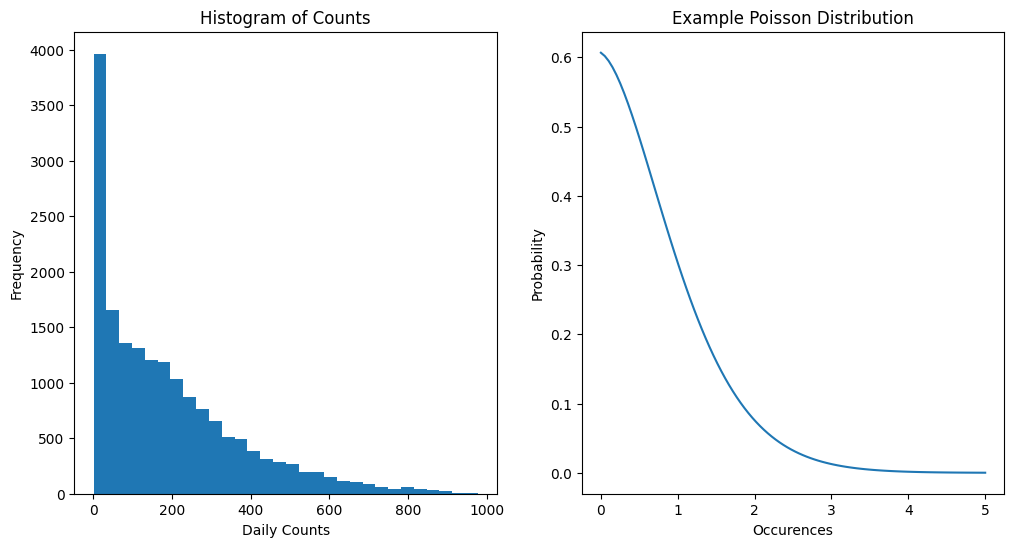

In [46]:
x = np.linspace(0,5,100)
l = 0.5
def f(t):
    result = (np.exp(-l) * l**t) / factorial(t)
    return result

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(hours_clean['cnt'],bins = 30)
ax1.set_title('Histogram of Counts')
ax1.set_xlabel('Daily Counts')
ax1.set_ylabel('Frequency')

ax2.plot(x,f(x))
ax2.set_title('Example Poisson Distribution')
ax2.set_xlabel('Occurences')
ax2.set_ylabel('Probability')


In [637]:
weights = torch.ones([1,X_train.shape[1]], requires_grad=True, dtype= torch.float32)

X_train_t = torch.tensor(X_train.values, dtype= torch.float32)
y_train_t = torch.tensor(y_train.values, dtype= torch.float32)
X_test_t = torch.tensor(X_test.values, dtype= torch.float32)
y_test_t = torch.tensor(y_test.values, dtype= torch.float32)



def batches(x, y, batch_size):
  for i in range(0, len(x), batch_size):
    yield x[i:i+batch_size], y[i:i+batch_size]

def forward(x,weights):
  z = x @ weights.T
  return torch.exp(z)

def loss(X,Y,weights):
    y_pred_batch = X @ weights.T
    loss = torch.sum(torch.exp(y_pred_batch)) - (y_pred_batch.T @ Y)
    return loss


lr = LR

for epoch in range(EPOCHS):
    # Reduce learning rate near end of training
    if epoch == 950:
       lr /= 10

    # Batch the data in each epoch using code provided in tutorial
    for i, (x, y) in enumerate(batches(X_train_t, y_train_t, BATCH_SIZE)):
        # Calculate loss function
        losses = loss(x,y,weights)
        losses.backward()
               
        # Update weights and reset gradient
        weights.data = weights.data - lr * weights.grad
        weights.grad.data.zero_()

# Make prediction on test dataset and record tweedie 
preds = forward(X_test_t, weights)
tweedie_score = d2_tweedie_score(y_test, preds.detach().numpy())

# Report tweedie D-score:
print("D-score of: {:.4f}".format(tweedie_score))

D-score of: 0.7499


### (j) Linear and Poisson Regression
TODO: compare the weights

We can't compare the weights for the locally weighted linear regression since the weights are dependent on the inputs we are performing the prediction on and so will change for every new input.

In [689]:
# OLS
ws_helper = w_ols.abs().to_numpy()[np.newaxis,:]
w_ols_pd = pd.DataFrame(ws_helper,columns = X_train.columns)
sorted_columns = w_ols_pd.columns[w_ols_pd.iloc[0].argsort()]
w_ols_sorted = w_ols_pd[sorted_columns]
print(w_ols_sorted.iloc[:,0:5])
print(w_ols_sorted.iloc[:,-5:])

   weekday_4    mnth_4  weekday_1  weekday_5  season_3
0    0.50803  0.610316   2.060529   2.323145  2.545842
         hr_4        hr_8       hr_18       hr_17        temp
0  159.693373  182.136056  222.913207  254.698681  258.880304


In [693]:
# Poisson
w_poisson_pd = pd.DataFrame(weights.detach().numpy(),columns = X_train.columns).abs()
sorted_columns = w_poisson_pd.columns[w_poisson_pd.iloc[0].argsort()]
w_poisson_sorted = w_poisson_pd[sorted_columns]
print(w_poisson_sorted.iloc[:,0:5])
print(w_poisson_sorted.iloc[:,-5:])

   windspeed     hr_0   holiday       hum      hr_1
0   0.111455  0.19689  0.200622  0.220094  0.262251
      hr_19      hr_4      hr_8     hr_18     hr_17
0  1.841257  1.848379  2.083214  2.137666  2.198854
